In [1]:
import xarray as xr
import matplotlib.pylab as plt
import Rbeast as rb
import numpy as np
import cartopy.crs as ccrss
import cartopy.feature as cf
import matplotlib as mpl
import pandas as pd
import my_funs
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import BallTree, DistanceMetric
from causalimpact import CausalImpact
import pickle
from sklearn.impute import IterativeImputer
from dask.diagnostics import ProgressBar
from tqdm import tqdm
from scipy import stats
from joblib import Parallel, delayed

mpl.rcParams["mathtext.default"] = "regular"
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from my_funs import outliers_index
dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/"

Initialization done!


/data/home/hamiddashti/hamid/nasa_above/greeness/codes/src/my_funs.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
2023-08-21 07:49:35.039735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the follo

In [73]:
ndvi = pd.read_pickle("../data/ndvi_array.pickle")/10000
lc = pd.read_pickle("../data/lc_array.pickle")
nir=pd.read_pickle("../data/nir_array.pickle")

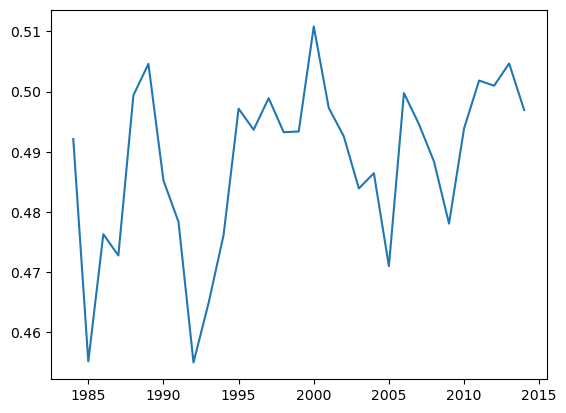

In [74]:
t=pd.date_range(start="1984",end="2015",freq="A").year
ndvi_all = ndvi[np.isfinite(ndvi).all(axis=1)]
ndvi_tm = ndvi_all[:,0:16]
ndvi_etm = ndvi_all[:,16:]
ndvi_etm_cor = (ndvi_etm+0.015)/1.095
ndvi_cor = np.concatenate([ndvi_tm,ndvi_etm_cor],axis=1)
ndvi_cor_mean = np.mean(ndvi_cor,0)
plt.plot(t,ndvi_cor_mean)

In [75]:
lc_all = lc[np.isfinite(lc).all(axis=1)]
# np.all(lc_all == lc_all[0])
I = []
for i in range(lc.shape[0]):
    if np.all(lc[i] == lc[i][0]):
        I.append(i)

In [76]:
ndvi_tm = ndvi[:,0:16]
ndvi_etm = ndvi[:,16:]
ndvi_etm_cor = (ndvi_etm+0.015)/1.095
ndvi_cor = np.concatenate([ndvi_tm,ndvi_etm_cor],axis=1)

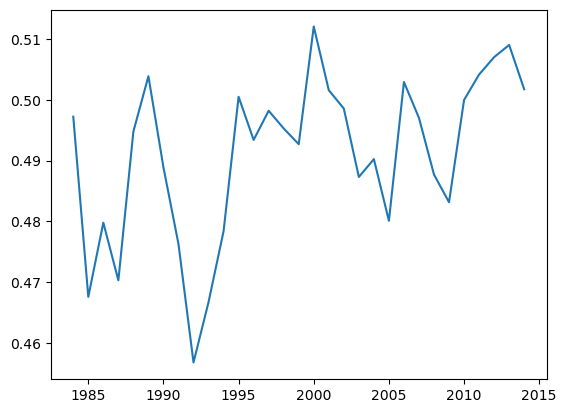

In [86]:
ndvi_tmp = ndvi_cor[I,:]
no_nan = (np.isfinite(ndvi_tmp).sum(axis=1)>29)
ndvi_not_changed = ndvi_tmp[no_nan,:]
plt.plot(t,np.nanmean(ndvi_not_changed,0))

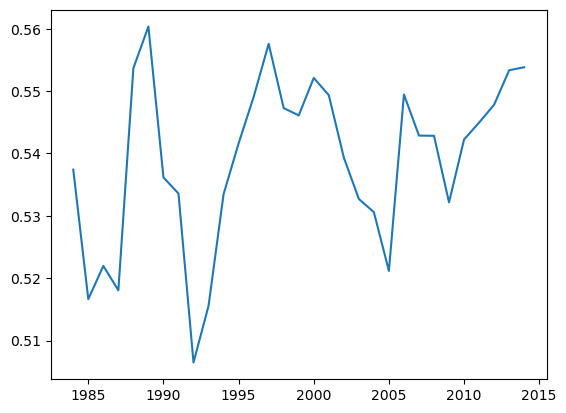

In [102]:
ndvi_tmp2 = np.delete(ndvi_cor,I,axis=0)
no_nan = (np.isfinite(ndvi_tmp2).sum(axis=1)>29)
ndvi_changed = ndvi_tmp2[no_nan,:]
plt.plot(t,np.nanmean(ndvi_changed,0))

In [95]:
ndvi_cor.shape

(2000000, 31)

In [ ]:
t=pd.date_range(start="1984",end="2015",freq="A").year
ndvi_all = ndvi2_array[np.isfinite(ndvi2_array).all(axis=1)]/10000
ndvi_tm = ndvi_all[:,0:16]
ndvi_etm = ndvi_all[:,16:]
ndvi_etm_cor = (ndvi_etm+0.015)/1.095
ndvi_cor = np.concatenate([ndvi_tm,ndvi_etm_cor],axis=1)
ndvi_cor_mean = np.mean(ndvi_cor,0)
plt.plot(t,ndvi_cor_mean)

In [2]:
n = 10000
tmp = xr.open_dataarray(dir+"mosaic_NDVI_1984_TM5.tif",engine="rasterio").squeeze()
rng = np.random.default_rng(seed=2)
lats = []
lons=[]
for i in tqdm(range(n)):
    lat = rng.choice(tmp.shape[0], 1, replace=False)
    lon = rng.choice(tmp.shape[1], 1, replace=False)
    lats.append(lat)
    lons.append(lon)
lats = np.array(lats).squeeze()
lons = np.array(lons).squeeze()

100%|██████████| 10000/10000 [00:00<00:00, 19395.80it/s]


In [3]:
def ndvi_extract(j,da):
    res = (da.isel(y=lats[j],x=lons[j]).values)
    return res

In [4]:
years = np.arange(1984,2015)
ndvi2 = []
for year in years:
    if year<=1999:
        fname = dir+"mosaic_NDVI_"+str(year)+"_TM5.tif"
        da = xr.open_dataarray(fname,engine="rasterio").squeeze()
        print(fname)
        # for j in tqdm(range(len(lats))):
        #     ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
        ndvi2.append(Parallel(n_jobs=16)(delayed(ndvi_extract)(j,da)
                              for j in range(len(lats))))
        continue
    fname = dir+"mosaic_NDVI_"+str(year)+"_ETM.tif"
    da = xr.open_dataarray(fname,engine="rasterio").squeeze()
    print(fname)
    # for j in tqdm(range(len(lats))):
    #     ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
    ndvi2.append(Parallel(n_jobs=16)(delayed(ndvi_extract)(j,da)
                              for j in range(len(lats))))
ndvi2_array = np.array(ndvi2).transpose()
with open('../../working/ndvi_array.pickle', 'wb') as handle:
    pickle.dump(ndvi2_array, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../../working/lats.pickle', 'wb') as handle:
    pickle.dump(lats, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../../working/lons.pickle', 'wb') as handle:
    pickle.dump(lons, handle, protocol=pickle.HIGHEST_PROTOCOL)

/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1984_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1985_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1986_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1987_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1988_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1989_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1990_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1991_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NDVI_1992_TM5.tif
/data/home/hamiddas

In [10]:
years = np.arange(1984,2015)
nir = []
for year in years:
    if year<=1999:
        fname = dir+"mosaic_NIR_"+str(year)+"_TM5.tif"
        da = xr.open_dataarray(fname,engine="rasterio").squeeze()
        print(fname)
        # for j in tqdm(range(len(lats))):
        #     ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
        nir.append(Parallel(n_jobs=16)(delayed(ndvi_extract)(j,da)
                              for j in range(len(lats))))
        continue
    fname = dir+"mosaic_NIR_"+str(year)+"_ETM.tif"
    da = xr.open_dataarray(fname,engine="rasterio").squeeze()
    print(fname)
    # for j in tqdm(range(len(lats))):
    #     ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
    nir.append(Parallel(n_jobs=16)(delayed(ndvi_extract)(j,da)
                              for j in range(len(lats))))
nir_array = np.array(nir).transpose()
with open('../../working/nir_array.pickle', 'wb') as handle:
    pickle.dump(nir_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1984_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1985_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1986_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1987_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1988_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1989_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1990_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1991_TM5.tif
/data/home/hamiddashti/hamid/nasa_above/greeness/data/processed_data/landsat/mosaic/mosaic_NIR_1992_TM5.tif
/data/home/hamiddashti/hamid

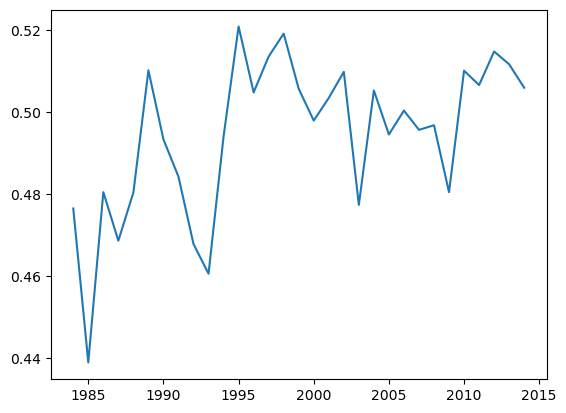

In [9]:
t=pd.date_range(start="1984",end="2015",freq="A").year
ndvi_all = ndvi2_array[np.isfinite(ndvi2_array).all(axis=1)]/10000
ndvi_tm = ndvi_all[:,0:16]
ndvi_etm = ndvi_all[:,16:]
ndvi_etm_cor = (ndvi_etm+0.015)/1.095
ndvi_cor = np.concatenate([ndvi_tm,ndvi_etm_cor],axis=1)
ndvi_cor_mean = np.mean(ndvi_cor,0)
plt.plot(t,ndvi_cor_mean)


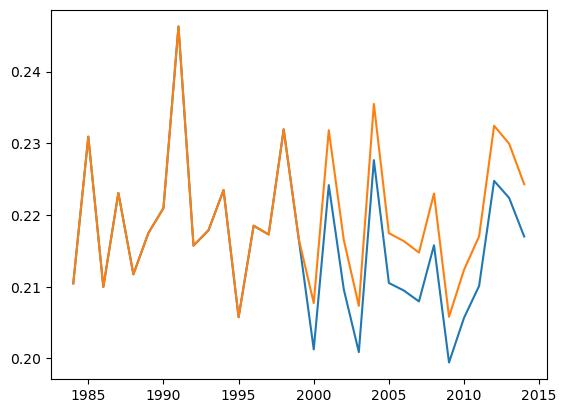

In [11]:
nir_all = nir_array[np.isfinite(ndvi2_array).all(axis=1)]/10000
nir_tm = nir_all[:,0:16]
nir_etm = nir_all[:,16:]
nir_etm_cor = (nir_etm+0.004)/1.052
nir_cor = np.concatenate([nir_tm,nir_etm_cor],axis=1)
nir_cor_mean = np.mean(nir_cor,0)
plt.plot(t,nir_cor_mean)
plt.plot(t,np.mean(nir_all,0))

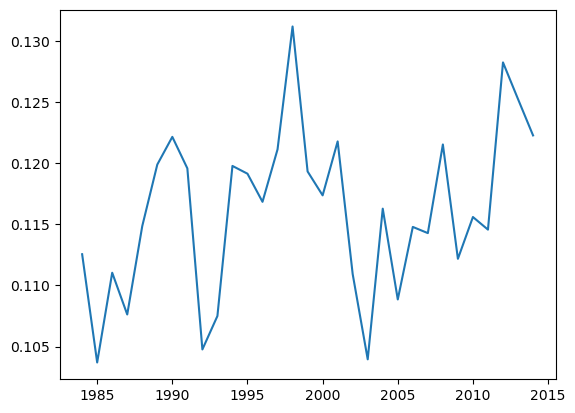

In [15]:
nirv = (nir_cor*ndvi_cor)
plt.plot(t,np.mean(nirv,0))

In [ ]:
#Sequential code
years = np.arange(1984,2015)
fname=[]
ndvi = []
for year in years:
    if year<=1999:
        fname = dir+"mosaic_NDVI_"+str(year)+"_TM5.tif"
        da = xr.open_dataarray(fname,engine="rasterio").squeeze()
        print(fname)
        for j in tqdm(range(len(lats))):
            ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
        continue
    fname = dir+"mosaic_NDVI_"+str(year)+"_ETM.tif"
    da = xr.open_dataarray(fname,engine="rasterio").squeeze()
    print(fname)
    for j in tqdm(range(len(lats))):
        ndvi.append(da.isel(y=lats[j],x=lons[j]).values)
ndvi_array = np.array(ndvi).reshape(n,len(years),order="F")
with open('../../working/ndvi.pickle', 'wb') as handle:
    pickle.dump(ndvi_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
ndvi_all = pd.read_pickle("../../working/ndvi_array.pickle")

In [ ]:
plt.plot(t,b_cor_mean)

In [ ]:
metadata = rb.args(whichDimIsTime=1, season="none", startTime=1984)
prior = rb.args(trendMinSepDist=3, trendMaxKnotNum=4)
mcmc = rb.args(seed=1)
extra = rb.args(  # a set of options to specify the outputs or computational configurations
    dumpInputData=
    True,  # make a copy of the aggregated input data in the beast ouput
    numThreadsPerCPU=2,  # Paralell  computing: use 2 threads per cpu core
    numParThreads=
    0,  # `0` means using all CPU cores: total num of ParThreads = numThreadsPerCPU * core Num
    printOptions=False,
    computeTrendSlope=True)
season = "none"
out_rbeast = rb.beast123(a, metadata, prior, mcmc, extra)

In [ ]:
y = out_rbeast.trend.Y
plt.plot(t,y.transpose())

In [ ]:
out2_rbeast = rb.beast(b_cor_mean,
                                  season="none",
                                  start=1984,
                                  tseg_minlength=3)
rb.plot(out2_rbeast)